# TP 4: Improve the Metropolis-Hastings algorithm

### Student : Simon Queric

## Exercise 1: Adaptive Metropolis-Hastings within Gibbs sampler

### 1.A – Metropolis-Hastings within Gibbs sampler

#### Question 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import pandas as pd
from scipy.stats import invgamma

In [2]:
a = 10
@jit(nopython=True)
def log_pi1(x, param) :
    y = param[0]
    a = param[1]
    return -x**2/a**2 - (x**2/a**2 - y**2)**2/4
@jit(nopython=True)
def log_pi2(y, param) :
    x = param[0]
    a = param[1]
    return -y**2 - (x**2/a**2 - y**2)**2/4

In [3]:
@jit(nopython=True)
def MH(x0, y0, a, n_iter=100, sigma1=3, sigma2=3) :
    X = np.zeros(n_iter)
    Y = np.zeros(n_iter)
    x = x0
    y = y0
    for i in range(n_iter) : 
        u = np.random.uniform(0, 1)
        if u <= 0.5 : 
            x_new = np.random.normal(x, sigma1)
            alpha = np.exp(min(0, log_pi1(x_new, (y, a)) - log_pi1(x, (y, a))))
            v = np.random.uniform(0, 1)
            if v <= alpha : 
                X[i]=x_new
                x = x_new
            else :
                X[i] = x
            Y[i] = y
        else : 
            y_new = np.random.normal(y, sigma2)
            alpha = np.exp(min(0, log_pi2(y_new, (x, a)) - log_pi2(y, (x, a))))
            v = np.random.uniform(0, 1)
            if v <= alpha : 
                Y[i]=y_new
                y = y_new
            else :
                Y[i] = y
            X[i] = x
            
    return X, Y

In [4]:
X, Y = MH(x0=1, y0=1, a=10, n_iter=2000, sigma1=3, sigma2=3)

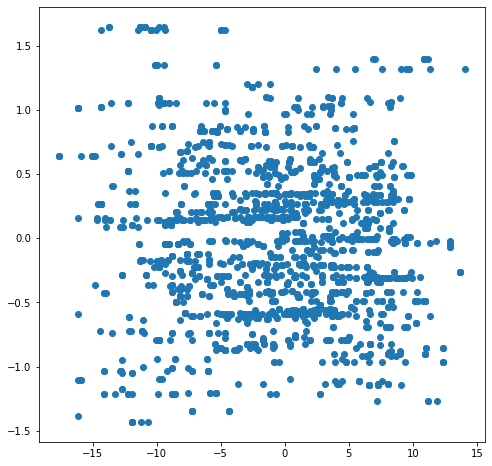

In [389]:
fig = plt.figure(figsize=(8, 8))
plt.scatter(X, Y)
plt.show()

In [390]:
X = (X - X.mean())/X.std()
Y = (Y - Y.mean())/Y.std()

In [391]:
def auto_corr(x):
    corr = np.correlate(x, x, mode="full")
    n = len(x)
    return corr[n-1:]

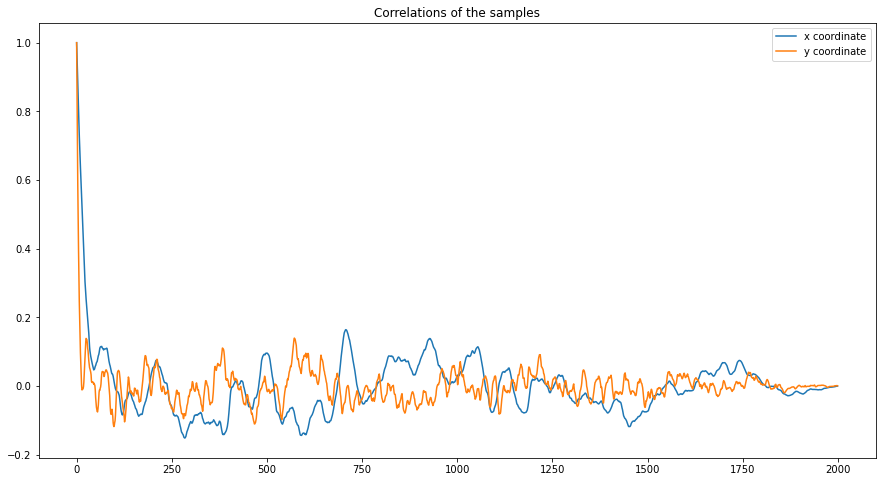

In [392]:
fig = plt.figure(figsize=(15, 8))
plt.plot(auto_corr(X)/len(X))
plt.plot(auto_corr(Y)/len(Y))
plt.title("Correlations of the samples")
plt.legend(["x coordinate", "y coordinate"])
plt.show()

3. The algorithm proposed is almost like a Gibbs sampler so we could think about implement a Gibbs sampler since the conditional densities are known. Another improvement would be to adaptatively chose the proposal variance.

In [393]:
@jit(nopython=True)
def MH_univariate(x0, log_pi, param, sigma_prop, n_iter):
    """
    Symmetric random walk Metropolis-Hasting algorithm for a real random variable 

    input
    -----
    x0 : initial point
    log_pi : log probability of the target density up to an additive constant
    param : parameters of the density
    n_iter : number of iteration of Metropolis-Hasting

    output
    ------
    x : last sample of MH
    alpha : last acceptance rate
    """
    x = x0
    for _ in range(n_iter) : 
        y = np.random.normal(x, sigma_prop) 
        alpha = np.exp(min(0, log_pi(y, param=param)-log_pi(x, param=param)))
        u = np.random.uniform(0, 1)
        if u<= alpha :
            x = y 
    return x, alpha

In [394]:
a = 10

In [395]:
log_pi1(1, (1, a))

-0.255025

In [428]:
def adaptative_MH_wG(x0, param, log_pis, sigmas, batch_size=50, hm_iter=100, n_iter=1000, adaptative=True) :
    """ 
    Implementation of the adaptative Gibbs sampler

    input
    -----
    x0 : initial point
    param : parameters of distribution
    log_pis : list of conditional log-probabilities
    sigmas : list of proposal variances for each coordinates
    hm_iter : number of Hasting-Metropolis iterations
    n_iter : number of Gibbs iteration

    output
    ------
    X : Markov chain trajectory
    Alphas : acceptance ratio
    """
    d = x0.shape[0]
    print(d)
    x_k = np.copy(x0)
    X = np.zeros((n_iter, d))
    l = np.log(sigmas)
    j=0
    alphas = np.zeros(d)
    Alphas = np.zeros((n_iter//batch_size, d))
    for k in range(n_iter):
        for i in range(d) :
            y = x_k[i]
            z = np.concatenate((x_k[:i], x_k[i+1:]))
            if d==2:
                z=z[0]
            x, alpha = MH_univariate(x_k[i], log_pis[i], param=(z, param), sigma_prop=np.exp(l[i]), n_iter=hm_iter)
            #alpha = np.exp(min(0, log_pis[i](y, param=(z, a))-log_pis[i](x, param=(z, a))))
            
            x_k[i] = x
            X[k,i] = x_k[i]
            alphas[i] += alpha #np.exp(min(0,log_pis[i](x_k[i], param=(z, a)) - log_pis[i](y, param=(z, a))))   
            
            if k>0 and k%batch_size==0:
                Alphas[k//batch_size, i] = alphas[i]/batch_size
                if adaptative :
                    
                    j = k//batch_size
                    delta_j = min(1e-2, 1/np.sqrt(j))
                    
                    if alphas[i]/batch_size < 0.24 :
                        l[i] -= delta_j
                        
                    elif alphas[i]/batch_size > 0.24 : 
                        l[i] += delta_j
                        
                alphas[i] = Alphas[-1,i]
                    
        
    return X, Alphas

In [429]:
x0 = np.ones(2)
n_iter=50_000
log_pis = [log_pi1, log_pi2]
X, Alphas = adaptative_MH_wG(x0, a, log_pis, sigmas=np.array([3, 3]), batch_size=50, hm_iter=100, n_iter=n_iter, adaptative=False)

2


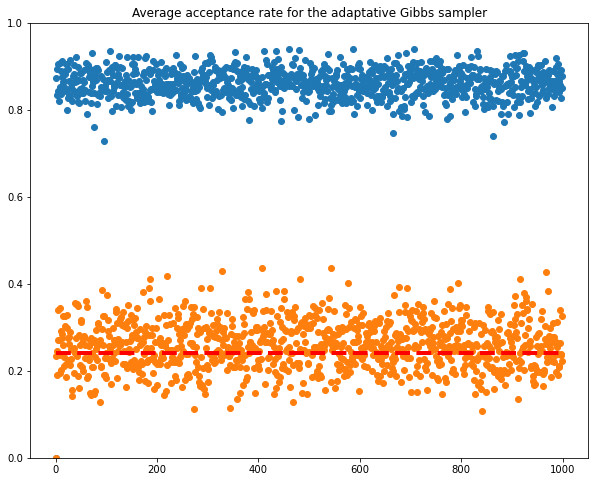

In [430]:
fig=plt.figure(figsize=(10, 8))
plt.plot(Alphas[:,0], 'o', lw=1)
plt.plot(Alphas[:,1], 'o', lw=1)
plt.hlines(0.24, 1, n_iter//50, "red", ls="--", lw=4)
plt.title("Average acceptance rate for the adaptative Gibbs sampler")
plt.ylim([0, 1])
plt.show()

In [431]:
x0 = np.ones(2)
n_iter=50_000
log_pis = [log_pi1, log_pi2]
X, Alphas = adaptative_MH_wG(x0, a, log_pis, sigmas=np.array([3, 3]), batch_size=50, hm_iter=100, n_iter=n_iter, adaptative=True)

2


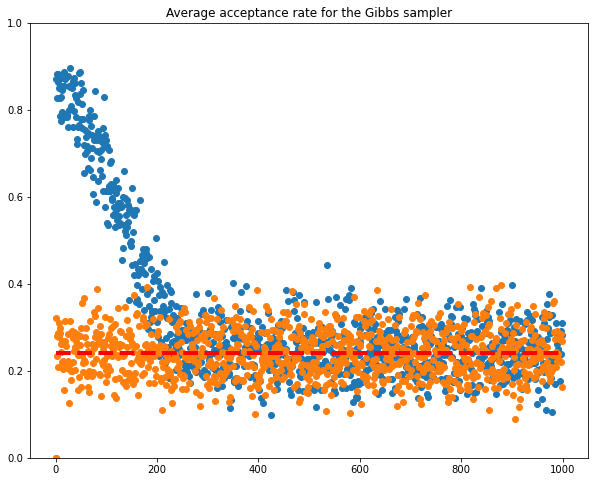

In [432]:
fig=plt.figure(figsize=(10, 8))
plt.plot(Alphas[:,0], 'o', lw=1)
plt.plot(Alphas[:,1], 'o', lw=1)
plt.hlines(0.24, 1, n_iter//50, "red", ls="--", lw=4)
plt.title("Average acceptance rate for the Gibbs sampler")
plt.ylim([0, 1])
plt.show()

For the non-adaptative Gibbs sampler, the proposal variance of the first coordinate is quite close to $1$. It means that we don't keep variables. It's not good because it's almost like if we sample a gaussian variable and not the true distribution.

We can see above that the for the adaptative sampler, the proposal variance of the first coordinate decrease and stay around $0.26$ which is what we wanted. 


In [433]:
X, Y = X[:,0], X[:,1]

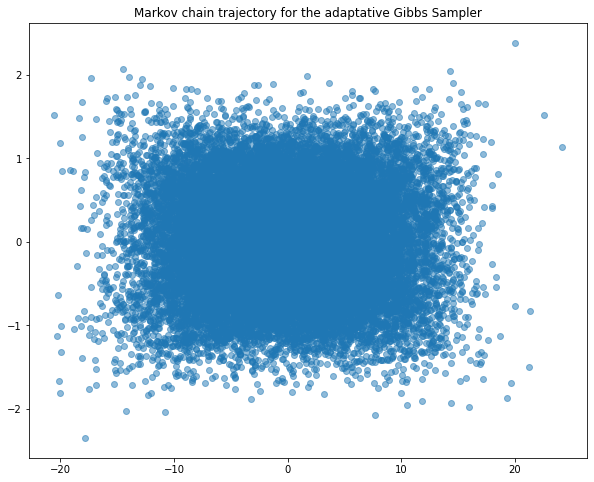

In [434]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(X[n_iter//2:], Y[n_iter//2:], alpha=.5)
plt.title("Markov chain trajectory for the adaptative Gibbs Sampler")
plt.show()

With the markov chain trajectory, we see that we don't have anymore the strong correlation that we had with the first algortithm.

In [426]:
X = (X - X.mean())/X.std()
Y = (Y - Y.mean())/Y.std()

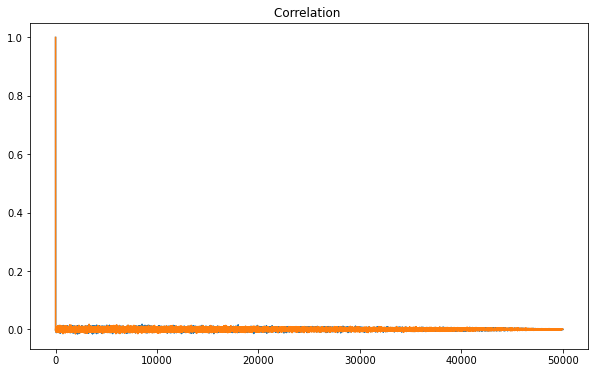

In [427]:
fig = plt.figure(figsize=(10, 6))
plt.plot(auto_corr(X)/len(X))
plt.plot(auto_corr(Y)/len(Y))
plt.title("Correlation ")
plt.show()

## Banana-shaped density

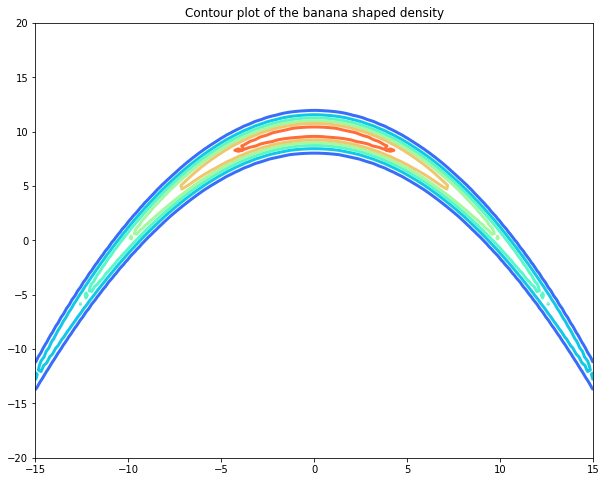

In [15]:
B = 0.1 
def f(x, y, B):  
    return np.exp(-x**2/200 - (y + B*x**2 - 100*B)**2/2)


fig = plt.figure(figsize=(10, 8))
x = np.linspace(-15, 15, 100)
y = np.linspace(-20, 20, 100)
X, Y = np.meshgrid(x, y)
Z = f(X, Y, B)
plt.contour(X, Y, Z, cmap="rainbow", linewidths=3)
plt.title("Contour plot of the banana shaped density")
plt.show()

In [22]:
a = 10
@jit(nopython=True)
def log_pi1(x, param) :
    y = param[0][0]
    B = param[1]
    return -x**2/200 - (y +B*x**2 - 100*B)**2/2
@jit(nopython=True)
def log_pi2(y, param) :
    x = param[0][0]
    B = param[1]
    return -(y +B*x**2 - 100*B)**2/2
@jit(nopython=True)
def log_pi_k(z, param):
    y = param[0][2:]
    return -(z**2+np.sum(y**2))/2

In [88]:
d = 20
x0 = np.zeros(d)
B = 0.1
n_iter=50_000
log_pis = [log_pi1, log_pi2] + [log_pi_k for _ in range(18)]

In [89]:
X, Alphas = adaptative_MH_wG(x0, B, log_pis, sigmas=3*np.ones(d), hm_iter=50, n_iter=n_iter)

20


In [ ]:
X, Y = X[:,0], X[:,1]

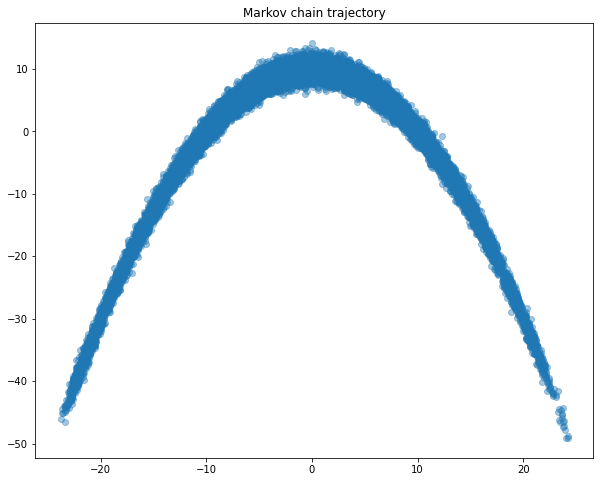

In [62]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(X[n_iter//2:], Y[n_iter//2:], alpha=.4)
x = np.linspace(-15, 15, 100)
y = np.linspace(-20, 20, 100)
x, y = np.meshgrid(x, y)
z = f(x, y, B)
#plt.contour(x, y, z, cmap='inferno', linewidths=3)
plt.title("Markov chain trajectory")
plt.show()

The markov chain trajectory fits the banana-shaped density.

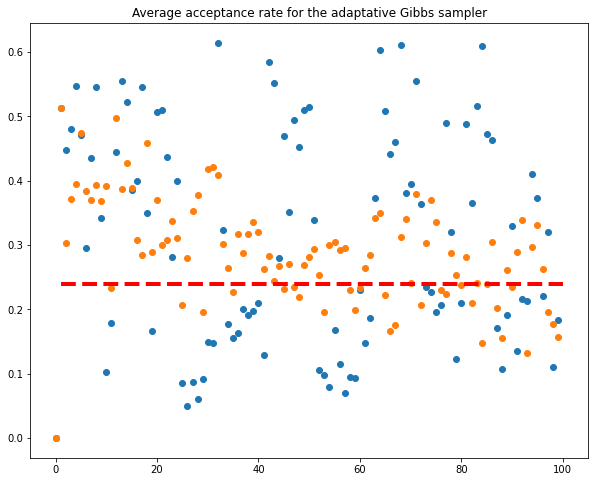

In [267]:
fig=plt.figure(figsize=(10, 8))
plt.plot(Alphas[:,0], 'o')
plt.plot(Alphas[:,1], 'o')
plt.hlines(0.24, 1, n_iter//50, "red", ls="--", lw=4)
plt.title("Average acceptance rate for the adaptative Gibbs sampler")
plt.show()

## Exercise 2 : Sampling from multimodal distributions

We want to sample from

\begin{equation*}
    \pi(x) = \sum_{i=1}^{20}{\frac{w_i}{\sqrt{2\pi\sigma_i^2}}\exp\left(-\frac{1}{2\sigma_i^2}\|x - \mu_i\|^2\right)}
\end{equation*}

In [345]:
d = 20
w = 0.05*np.ones(d)
sigma = 0.1*np.ones(d)
sigma=0.1
mu = np.array([[2.18, 5.76], [8.67, 9.59], [4.24, 8.48], [8.41, 1.68], [3.93, 8.82],
               [3.25, 3.47], [1.70, 0.50], [4.59, 5.60], [6.91, 5.81], [6.87, 5.40],
               [5.41, 2.65], [2.70, 7.88], [4.98, 3.70], [1.14, 2.39], [8.33, 9.50],
               [4.93, 1.50], [1.83, 0.09], [2.26, 0.31], [5.54, 6.86], [1.69, 8.11]])

In [346]:
np.linalg.norm(mu - np.array([0, 0]), axis=1)

array([ 6.15873364, 12.92814759,  9.48092822,  8.57615881,  9.65594635,
        4.75430331,  1.77200451,  7.2407251 ,  9.02796766,  8.73824353,
        6.02416799,  8.32972989,  6.20406318,  2.64796148, 12.63482885,
        5.15314467,  1.83221178,  2.28116198,  8.81766409,  8.2842139 ])

In [347]:
@jit(nopython=True)
def logsumexp(x) :
    c = np.max(x)
    return c + np.log(np.sum(np.exp(x-c)))

In [348]:
Z.shape

(1000, 43)

In [349]:
def f(x, y, mu):
    Z = np.zeros((len(x), len(y)))
    for i in range(len(x)):
        for j in range(len(y)):
            z = np.zeros(len(mu))
            for k in range(len(mu)) :
                z[k] = (-(x[i]-mu[k, 0])**2 - (y[j]-mu[k, 1])**2)/(2*sigma**2) + np.log(0.05/np.sqrt(2*np.pi*sigma**2))
            Z[i, j] = logsumexp(z)
    return Z

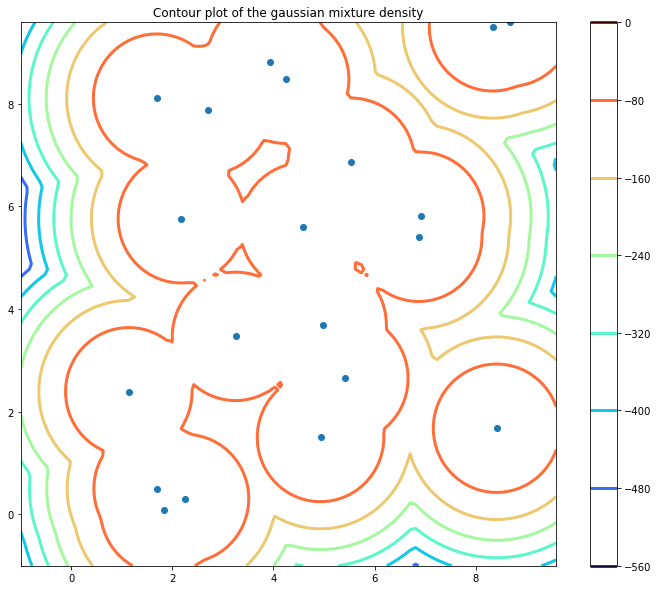

In [350]:
from matplotlib.colors import LogNorm
fig = plt.figure(figsize=(12, 10))
x = np.linspace(-1, np.max(mu), 100)
y = np.linspace(-1, np.max(mu), 100)
X, Y = np.meshgrid(x, y)
Z = f(x, y, mu)
plt.scatter(mu[:,0], mu[:,1])
plt.contour(X, Y, Z.T, cmap="rainbow", linewidths=3) #, levels=np.linspace(-560, -0.01))
plt.colorbar()
plt.title("Contour plot of the gaussian mixture density")
plt.show()

In [351]:
@jit(nopython=True)
def log_pi(x, param) :
    mu = param[0]
    sigma = param[1]
    y = x - mu
    z = np.zeros(len(y))
    for i in range(len(y)):
        z[i] = -np.linalg.norm(y[i])**2/(2*sigma**2)
    return logsumexp(z)

In [352]:
def MH(x0, log_pi, param, sigma_prop=1e-2, n_iter=100):
    """
    Symmetric random walk Metropolis-Hasting algorithm for a multivariate random variable 

    input
    -----
    x0 : initial point
    log_pi : log probability of the target density up to an additive constant            Yi = np.random.multivariate_normal(mean=X[i], cov=sigma_prop[i]*np.eye(d))
            a = np.exp(min(0,  log_pi(Yi, param=param)/T[i] - log_pi(X[i], param=param)/T[i]))
            u = np.random.uniform(0, 1)
            if u<=a:

    param : parameters of the density
    sigma_prop : variance of the proposal kernel 
    n_iter : number of iteration of Metropolis-Hasting

    output
    ------
    X : samples of Metropolis-Hasting
    """
    x = np.copy(x0)
    d = x.shape[0]
    X = np.zeros((n_iter, d))
    for k in range(n_iter) : 
        y = np.random.multivariate_normal(mean=x, cov=sigma_prop**2 *np.eye(d))
        alpha = np.exp(min(0, log_pi(y, param=param)-log_pi(x, param=param)))
        u = np.random.uniform(0, 1)
        if u<= alpha :
            x = y 

        X[k] = x
    return X

In [353]:
x0 = np.array([1.70, 0.50])
sigma = 0.1
param = (mu, sigma)
n_iter = 1000

In [354]:
X = MH(x0, log_pi, param, sigma_prop=1, n_iter=n_iter)

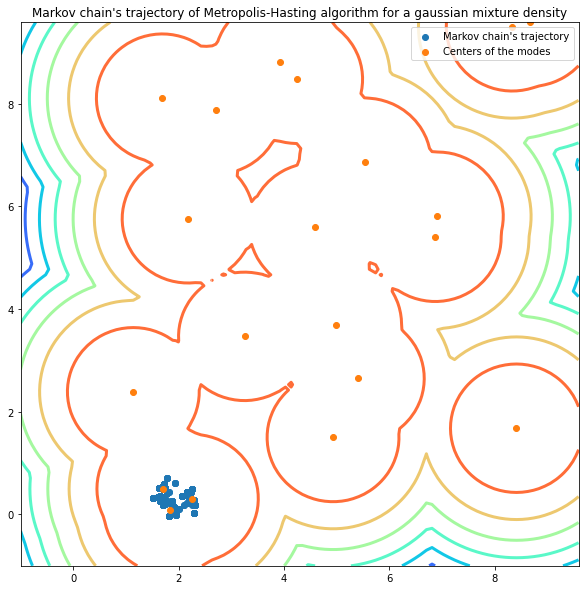

In [355]:
fig=plt.figure(figsize=(10, 10))
plt.scatter(X[:,0], X[:,1])
plt.scatter(mu[:,0], mu[:,1])
u = np.linspace(-1, np.max(mu), 100)
v = np.linspace(-1, np.max(mu), 100)
W = f(u, v, mu)
U, V = np.meshgrid(x, y)
plt.contour(U, V, W.T, cmap="rainbow", linewidths=3) #, levels=np.linspace(-560, -0.01))
plt.legend(["Markov chain's trajectory", "Centers of the modes"])
plt.title("Markov chain's trajectory of Metropolis-Hasting algorithm for a gaussian mixture density")
plt.show()

We can see that the classical Symmetric Random Walk MH algorithm fails to sample from the distribution $\pi$. Indeed, the chain visits only between three and 5 modes over twenty.
This is due to the fact that the Markov chain makes small step and therefore doesn't visit all space states. 

## 2.B – Parallel Tempering

In [300]:
@jit(nopython=True)
def parallel_tempering(X0, log_pi, K, T, param, sigma_prop, n_iter=100):
    d = X0[0].shape[0]
    X = np.copy(X0)
    Z = np.zeros((n_iter, K, d))
    for n in range(n_iter) :
        for i in range(K) :
            Yi = np.zeros(2)
            Yi[0] = np.random.normal(X[i, 0], sigma_prop[i])
            Yi[1] = np.random.normal(X[i, 1], sigma_prop[i])
            #Yi = np.array([np.random.normal(X[i, 0], sigma_prop[i]), np.random.normal(X[i, 1], sigma_prop[i])]) #np.random.multivariate_normal(mean=X[i], cov=sigma_prop[i]*np.eye(d))
            a = np.exp(min(0,  log_pi(Yi, param=param)/T[i] - log_pi(X[i], param=param)/T[i]))
            u = np.random.uniform(0, 1)
            if u<=a:
                X[i] = Yi
                Z[n, i] = Yi
            else :
                Z[n, i] = X[i]
        
        i = np.random.randint(K)
        if i==0 :
            j=i+1
        elif i==K-1:
            j=i-1
        else :
            u = np.random.uniform(0, 1)
            if u<0.5:
                j=i-1
            if u>=0.5:
                j=i+1
        
        swap_acc = np.exp(min(0, log_pi(X[i], param=param)/T[j] + log_pi(X[j], param=param)/T[i] \
                              - log_pi(X[j], param=param)/T[j] + log_pi(X[i], param=param)/T[i]))
        u = np.random.uniform(0, 1)
        if u<=swap_acc :
            X[i], X[j] = X[j], X[i]
            Z[n, i] = X[i]
            Z[n, j] = X[j]     


    return Z

In [359]:
K = 5
T = np.array([60, 21.6, 7.7, 2.8, 1])
sigma_prop = 0.25*np.sqrt(T)
X0 = np.zeros((K, 2))

In [360]:
Z = parallel_tempering(X0, log_pi, K, T, param = (mu, sigma), sigma_prop=sigma_prop, n_iter=50_000)

In [361]:
Z.shape

(50000, 5, 2)

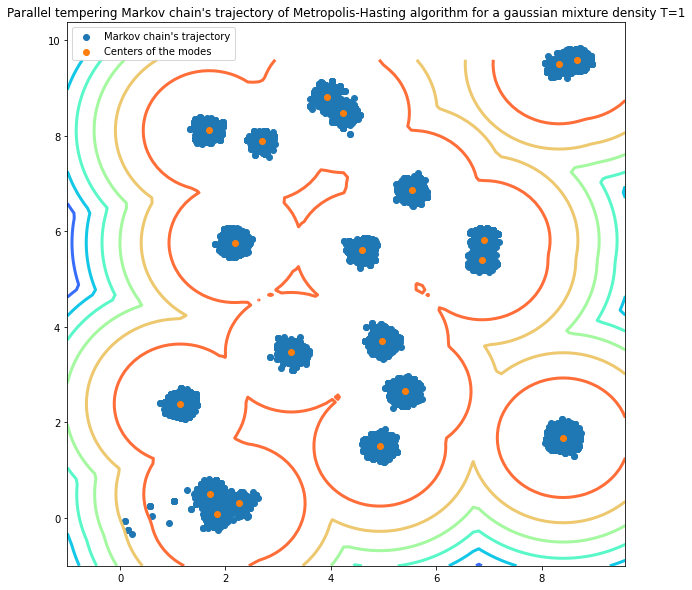

In [364]:
fig=plt.figure(figsize=(10, 10))
plt.scatter(Z[:,-1,0], Z[:,-1,1])
plt.scatter(mu[:,0], mu[:,1])
u = np.linspace(-1, np.max(mu), 100)
v = np.linspace(-1, np.max(mu), 100)
W = f(u, v, mu)
U, V = np.meshgrid(x, y)
plt.contour(U, V, W.T, cmap="rainbow", linewidths=3) #, levels=np.linspace(-560, -0.01))
plt.legend(["Markov chain's trajectory", "Centers of the modes"])
plt.title("Parallel tempering Markov chain's trajectory of Metropolis-Hasting algorithm for a gaussian mixture density T=1")
plt.show()

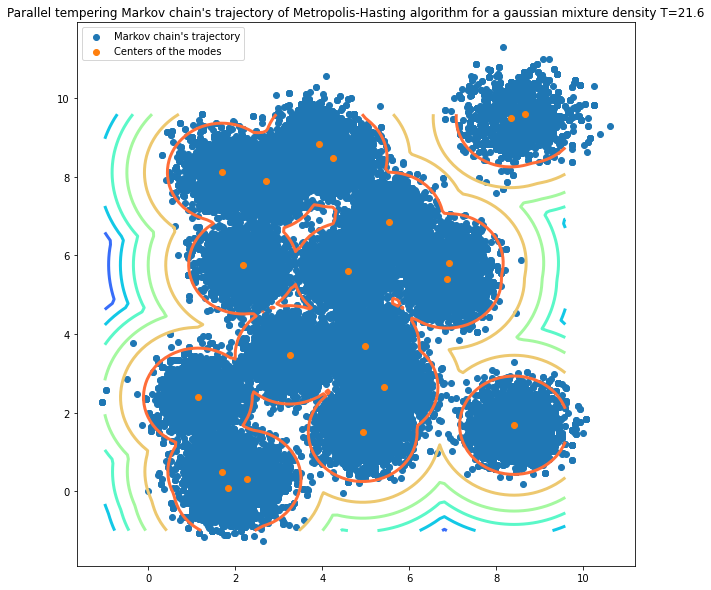

In [365]:
fig=plt.figure(figsize=(10, 10))
plt.scatter(Z[:,-4,0], Z[:,-4,1])
plt.scatter(mu[:,0], mu[:,1])
u = np.linspace(-1, np.max(mu), 100)
v = np.linspace(-1, np.max(mu), 100)
W = f(u, v, mu)
U, V = np.meshgrid(x, y)
plt.contour(U, V, W.T, cmap="rainbow", linewidths=3) #, levels=np.linspace(-560, -0.01))
plt.legend(["Markov chain's trajectory", "Centers of the modes"])
plt.title("Parallel tempering Markov chain's trajectory of Metropolis-Hasting algorithm for a gaussian mixture density T=21.6")
plt.show()

## Exercise 3 : Bayesian analysis of a one-way random effects model

$\alpha, \beta, \gamma :$ known hyperparameters.

In [7]:
def gen_data(N, K, alpha, beta, gamma, mu) :
    sigma2 = invgamma.rvs(a=alpha, scale=beta)
    tau2 = invgamma.rvs(a=gamma, scale=beta)
    X = np.random.normal(mu,  np.sqrt(sigma2), size=N)
    eps = np.random.normal(0, np.sqrt(tau2), size=(N, K))
    y = np.zeros_like(eps)

    for i in range(N):
        y[i] = X[i] + eps[i]

    return y, X, mu, sigma2, tau2

In [8]:
# hyperparameters
N = 40
K = 10
alpha = 3
beta = 2
gamma = 2
mu = 2

In [28]:
y, X, mu, sigma2, tau2 = gen_data(N, K, alpha, beta, gamma, mu)

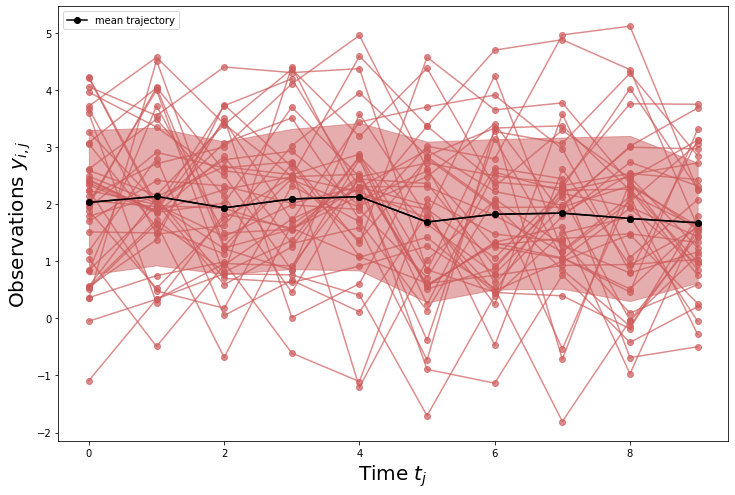

In [29]:
fig = plt.figure(figsize=(12, 8))
y_mean = y.mean(axis=0)
y_std = y.std(axis=0)
plt.plot(y_mean, "k", marker='o')
for n in range(N) :
    plt.plot(y[n,:], alpha=0.7, color="indianred", ls='-', marker='o')
plt.plot(y_mean, "k", marker='o')
plt.fill_between(list(range(K)), y_mean-y_std, y_mean+y_std, alpha=0.5, color="indianred")
plt.legend(["mean trajectory"])
plt.xlabel("Time $t_j$", fontsize=20)
plt.ylabel("Observations $y_{i, j}$", fontsize=20)
plt.show()

The density of the posterior distribution of $(X, \mu, \sigma^2, \tau^2)$ writes : 

\begin{equation*}
    \pi(X, \mu, \sigma^2, \tau^2 \mid y) \propto \frac{1}{\sigma^{2(1+\alpha) + N}}\exp\left(\frac{-\beta - 1/2\sum_{i=1}^N{(X_i-\mu)^2}}{\sigma^2}\right)\frac{1}{\tau^{2(1+\gamma) + NK}} \exp\left(\frac{-\beta - 1/2\sum_{i,j}{(y_{i,j}-X_i)^2}}{\tau^2}\right)
\end{equation*}

Hence, we have the following conditional distributions :

\begin{equation*}
    \begin{aligned}
    \mathcal{L}(\sigma^2 \mid y, X, \mu, \tau^2) &= \text{Inverse-Gamma}(N/2+\alpha, \beta + 1/2\sum_{i=1}^N{(X_i-\mu)^2}) \\
    \mathcal{L}(\tau^2 \mid y, X, \mu, \sigma^2) &= \text{Inverse-Gamma}(KN/2+\gamma, \beta + 1/2\sum_{i,j}{(y_{i,j}-X_i)^2}) \\
     \mathcal{L}(X_i \mid y, \mu, \sigma^2, \tau^2) &= \mathcal{N}\left(\left(\frac{1}{\sigma^2}+\frac{K}{\tau^2}\right)^{-1} \left(\frac{\mu}{\sigma^2} + \frac{1}{\tau^2}\sum_{j=1}^K{y_{i,j}}\right) , \left(\frac{1}{\sigma^2}+\frac{K}{\tau^2}\right)^{-1}\right) \\
     \mathcal{L}(\mu \mid y, X, \sigma^2) &= \mathcal{N}(\overline{X}, \sigma^2/N)
    \end{aligned}

\end{equation*}

In [30]:
def MH_wG(z0, y, n_iter=50) :
    z = np.copy(z0)
    N = len(z)
    X = z[:-3]
    mu = z[-3]
    sigma2 = z[-2]
    tau2 = z[-1]
    Z = np.zeros((n_iter, N))
    for i in range(n_iter) :
        sigma2 = invgamma.rvs(a=N/2+alpha, scale=beta+np.sum((X - mu)**2)/2)
        Z[i,-2] = sigma2
        tau2 = invgamma.rvs(a=N*K/2+gamma, scale=beta+np.sum((y.T-X)**2)/2)
        Z[i,-1] = tau2 
        mu = np.random.normal(np.mean(X), np.sqrt(sigma2/N))
        Z[i,-3] = mu
        X = np.random.multivariate_normal(mean=(y.sum(axis=1)/tau2 + mu/sigma2)/(K/tau2 + 1/sigma2), 
                                   cov=1/(K/tau2 + 1/sigma2)*np.eye(N-3))
        Z[i,:-3] = X
        
    return Z

In [31]:
z0 = np.zeros(N+3)
z0[:-3] = -500
z0[-2] = 1e10
z0[-1] = 1e10
z_true = np.zeros(N+3)
z_true[:-3] = X
z_true[-3] = mu
z_true[-2] = sigma2
z_true[-1] = tau2


Z = MH_wG(z0, y, n_iter=1000)

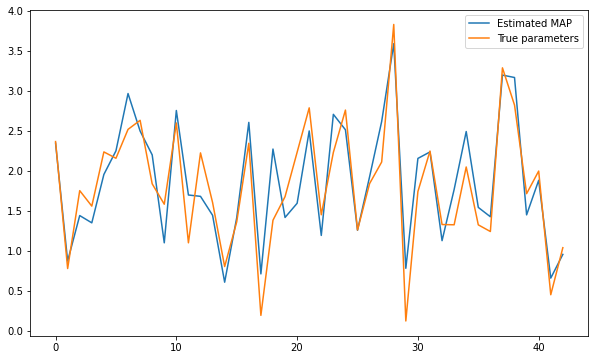

In [32]:
fig = plt.figure(figsize=(10, 6))
plt.plot(Z[-1])
plt.plot(z_true)
plt.legend(["Estimated MAP", "True parameters"])
plt.show()

In the Gibbs block setting we sample $\sigma^2$ then $\tau^2$ and the couple $(X, \mu)$ :

\begin{equation*}
    \begin{aligned}
    \mathcal{L}(\sigma^2 \mid y, X, \mu, \tau^2) &= \text{Inverse-Gamma}(N/2+\alpha, \beta+ 1/2\sum_{i=1}^N{(X_i-\mu)^2}) \\
    \mathcal{L}(\tau^2 \mid y, X, \mu, \sigma^2) &= \text{Inverse-Gamma}(KN/2+\gamma, \beta + 1/2\sum_{i,j}{(y_{i,j}-X_i)^2}) \\
    \mathcal{L}(X, \mu \mid y, \sigma^2, \tau^2) &= \mathcal{N}(m, \Sigma)
    \end{aligned}
\end{equation*}

where $$m = (K\overline{y_1}, \cdots, K\overline{y_N}, 0)^T /(\tau^2/\sigma^2 + K)$$

and 

$$ \Sigma^{-1} = \begin{pmatrix} 
                    \eta & 0 & \cdots & 0 & -1/\sigma^2  \\
                    0 & \eta & \ddots & \vdots & \vdots\\
                    \vdots & \ddots & \ddots & 0 & \vdots \\
                    0 & \cdots &  0 & \eta & -1/\sigma^2\\
                    -1/\sigma^2 & \cdots & \cdots & -1/\sigma^2 & N/ \sigma^2
                
                \end{pmatrix}$$

where $\displaystyle \eta = \left(\frac{1}{\sigma^2} + \frac{K}{\tau^2} \right) = (\tau^2 + K\sigma^2)/K\sigma^2$

In [36]:
def block_MH_wG(z0, y, n_iter=50) :
    z = np.copy(z0)
    N = len(z)
    print(N)
    Xmu = z[:-2]
    sigma2 = z[-2]
    tau2 = z[-1]
    Z = np.zeros((n_iter, N))
    for i in range(n_iter) :
        sigma2 = invgamma.rvs(a=N/2+alpha, scale=beta+np.sum((X - mu)**2)/2)
        Z[i,-2] = sigma2
        tau2 = invgamma.rvs(a=N*K/2+gamma, scale=beta+np.sum((y.T-X)**2)/2)
        Z[i,-1] = tau2 
        eta = (1/sigma2 + K/tau2)
        Sigma_inv = np.zeros((N-2, N-2))
        
        Sigma_inv[:N-3,:N-3] = eta*np.eye(N-3)
        Sigma_inv[-1, :-1] = -1/sigma2
        Sigma_inv[:-1,-1] = -1/sigma2
        Sigma_inv[-1,-1] = N/sigma2 
        Sigma_inv += 0#1e-5*np.eye(N-2)
        m = np.zeros(N-2)
        m[:N-3] = y.sum(axis=1) / (tau2/sigma2 + K)
        Xmu = np.random.multivariate_normal(mean=m, 
                                   cov=np.linalg.inv(Sigma_inv))
        Z[i,:-2] = Xmu
        
    return Z

In [37]:
z0 = np.zeros(N+3)
z0[:-3] = 1
z0[-2] = 1
z0[-1] = 0.5

Z = block_MH_wG(z0, y, n_iter=1000)

43


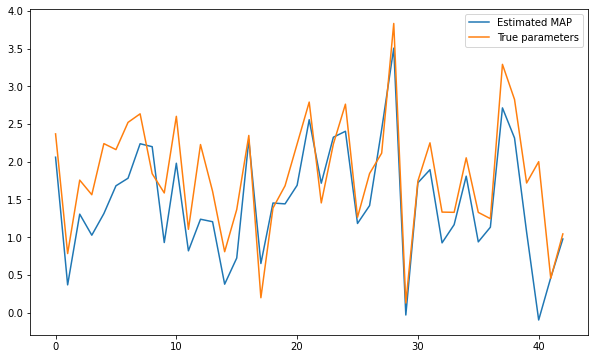

In [39]:
fig = plt.figure(figsize=(10, 6))
plt.plot(Z[-1])
plt.plot(z_true)
plt.legend(["Estimated MAP", "True parameters"])
plt.show()

Here, we can't really show that the block Gibbs algorithm is different because we know how to sample the conditional laws of the parameters. 

The block Gibbs algorithm is useful to divide the running time when we run MCMC algorithm inside Gibbs like Hasting-Metropolis.